# Librairies

In [8]:
# System and files
import os
import time
import pickle
import logging
from tqdm import tqdm
from datetime import datetime
from pathlib import Path
from collections import defaultdict

# Files and data
import itertools
import numpy as np
import polars as pl
import fastparquet as fp
import pyarrow.parquet as pq

# Vizualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tqdm import tqdm

# Maths
from scipy.optimize import curve_fit
from random import *
import math

# Fitting and plots
from fitting import fitting_in_superposition, fitting_in_two_steps
from plot_tools import *

# Plot 1D : Everything about 1 config

In [9]:
def find_parquet_and_load(root_directory: str, **params) -> pl.DataFrame:
    """
    Search for a parquet file in folder subfolders and check the specified values.
    Then load the parquet file as a Polars DataFrame.

    Args:
        root_directory (str): The root directory path to browse.
        **params: Keyword arguments representing the values to check in folder names.

    Returns:
        pl.DataFrame or None: Returns a Polars DataFrame if a matching file is found, otherwise None.
    """

    # List of subfolders in the root folder
    subdirs = [
        os.path.join(root_directory, d)
        for d in os.listdir(root_directory)
        if os.path.isdir(os.path.join(root_directory, d))
    ]

    # Main loop to iterate over subfolders
    for subdir in tqdm(subdirs, desc="Loading subfiles", unit=" subfiles"):
        for dirpath, dirnames, filenames in os.walk(subdir):  # Browse subfolders
            for dirname in dirnames:
                folder_name = dirname

                # Check if all parameters match in the folder name
                if all(f"{key}_{value}__" in folder_name for key, value in params.items()):
                    # Path of the matching subfolder
                    subdir_path = os.path.join(dirpath, folder_name)
                    print(f"Corresponding subfile found: {subdir_path}")

                    # Look for .parquet files with 'data' in their name
                    for filename in os.listdir(subdir_path):
                        if filename.endswith('.parquet') and 'data' in filename:
                            pq_path = os.path.join(subdir_path, filename)
                            try:
                                # Load data using pyarrow and convert to Polars DataFrame
                                data = pq.read_table(pq_path)
                                df_polars = pl.DataFrame(data)
                                print('Values:', df_polars.columns)
                                pl.Config.set_tbl_cols(len(df_polars.columns))
                                print(df_polars.head())
                                print('Verification of data availability:', df_polars['times'].to_numpy())
                                return df_polars
                            except Exception as e:
                                print("Error loading parquet:", e)
                                return None

    # No matching folders found
    print("No sub-folders match the specified criteria.")
    return None

# Parameters
# root_directory = '/home/nicolas/data_test/'
root_directory = '/home/nicolas/Documents/Progs/nucleo_folder_Xnfs/'

params = {
    "alpha_choice": 'nt_random',
    "s": 150,
    "l": 10,
    "bpmin": 0,
    "mu": 320,
    "theta": 50,
    "nt": 10000,
    "tmax": 100,
    "dt": 1,
    "alphao": 0,
    "alphaf": 1,
    "beta": 0,
    "Lmin": 0,
    "Lmax": 50000,
    "origin": 10000,
    "bps": 1,
}

df_polars = find_parquet_and_load(root_directory, **params)

Loading subfiles:  75%|███████▌  | 72/96 [00:00<00:00, 78.52 subfiles/s]

Corresponding subfile found: /home/nicolas/Documents/Progs/nucleo_folder_Xnfs/data_nucleo_nu_task_3/__alpha_choice_nt_random__s_150__l_10__bpmin_0__mu_320__theta_50__nt_10000__tmax_100__dt_1__alphao_0__alphaf_1__beta_0__Lmin_0__Lmax_50000__origin_10000__bps_1__
Values: ['alpha_choice', 's', 'l', 'bpmin', 'mu', 'theta', 'nt', 'tmax', 'dt', 'times', 'alphao', 'alphaf', 'beta', 'Lmin', 'Lmax', 'origin', 'bps', 'alpha_mean', 'obs_points', 'obs_distrib', 'link_points', 'link_distrib', 'p', 'results', 'results_mean', 'results_med', 'results_std', 'v_mean', 'v_med', 'vf', 'Cf', 'wf', 'vf_std', 'Cf_std', 'wf_std', 'bin_fpt', 'fpt_distrib_2D', 'fpt_number', 'tbj_points', 'tbj_distrib', 'dx_points', 'dx_distrib', 'dx_mean', 'dx_med', 'dx_mp', 'dt_points', 'dt_distrib', 'dt_mean', 'dt_med', 'dt_mp', 'vi_points', 'vi_distrib', 'vi_mean', 'vi_med', 'vi_mp', 'alpha_0', 'epsilon_t']
shape: (1, 57)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─

In [10]:
# --- Getting all the values ---#

alpha_choice = df_polars['alpha_choice'][0]
s = df_polars['s'][0]
l = df_polars['l'][0]
bpmin = df_polars['bpmin'][0]
mu = df_polars['mu'][0]
theta = df_polars['theta'][0]
nt = df_polars['nt'][0]
tmax = df_polars['tmax'][0]
dt = df_polars['dt'][0]
times = df_polars['times'][0].to_numpy()
alphao = df_polars['alphao'][0]
alphaf = df_polars['alphaf'][0]
beta = df_polars['beta'][0]
Lmin = df_polars['Lmin'][0]
Lmax = df_polars['Lmax'][0]
origin = df_polars['origin'][0]
bps = df_polars['bps'][0]


alpha_mean = df_polars['alpha_mean'][0].to_numpy()
obs_points = df_polars['obs_points'][0].to_numpy()
obs_distrib = df_polars['obs_distrib'][0].to_numpy()
link_points = df_polars['link_points'][0].to_numpy()
link_distrib = df_polars['link_distrib'][0].to_numpy()


p = df_polars['p'][0].to_numpy()


results = np.array(df_polars["results"].to_list())[0]
results_mean = df_polars['results_mean'][0].to_numpy()
results_med = df_polars['results_med'][0].to_numpy()
results_std = df_polars['results_std'][0].to_numpy()
v_mean = df_polars['v_mean'][0]
v_med = df_polars['v_med'][0]


bin_fpt = df_polars['bin_fpt'][0]
fpt_distrib_2D = np.array(df_polars["fpt_distrib_2D"].to_list())[0]
fpt_number = df_polars['fpt_number'][0].to_numpy()


tbj_points = df_polars['tbj_points'][0].to_numpy()
tbj_distrib = df_polars['tbj_distrib'][0].to_numpy()


dx_points = df_polars['dx_points'][0].to_numpy()
dx_distrib = df_polars['dx_distrib'][0].to_numpy()
dx_mean = df_polars['dx_mean'][0]
dx_med = df_polars['dx_med'][0]
dx_mp = df_polars['dx_mp'][0]

dt_points = df_polars['dt_points'][0].to_numpy()
dt_distrib = df_polars['dt_distrib'][0].to_numpy()
dt_mean = df_polars['dt_mean'][0]
dt_med = df_polars['dt_med'][0]
dt_mp = df_polars['dt_mp'][0]

vi_points = df_polars['vi_points'][0].to_numpy()
vi_distrib = df_polars['vi_distrib'][0].to_numpy()
vi_mean = df_polars['vi_mean'][0]
vi_med = df_polars['vi_med'][0]
vi_mp = df_polars['vi_mp'][0]


alpha_0 = df_polars['alpha_0'][0]
epsilon_t = df_polars['epsilon_t'][0]

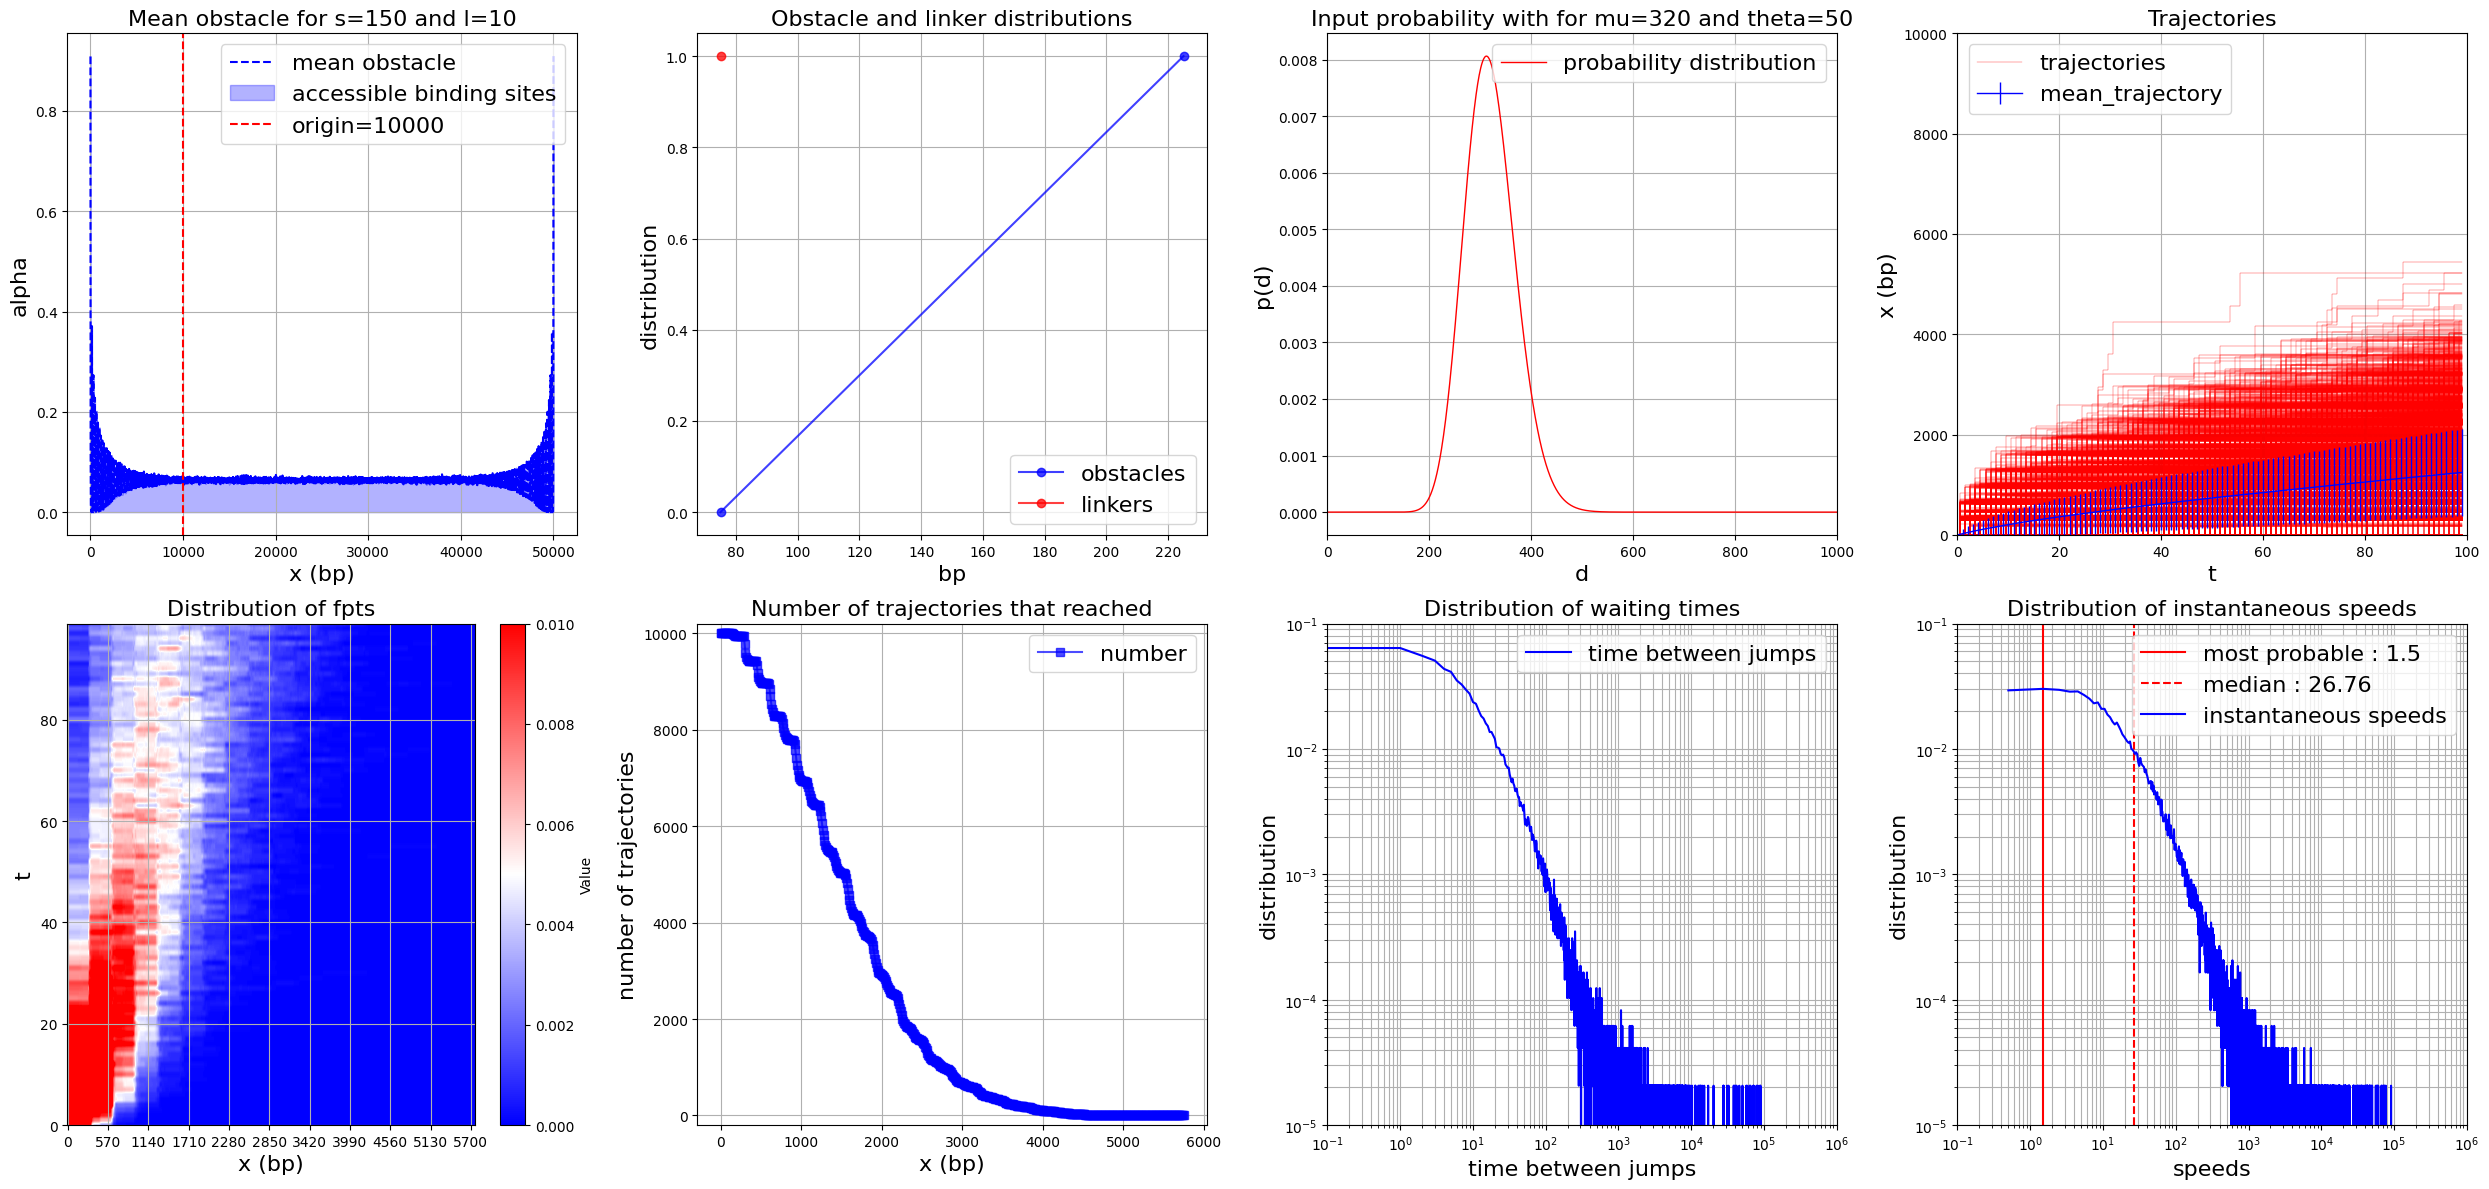

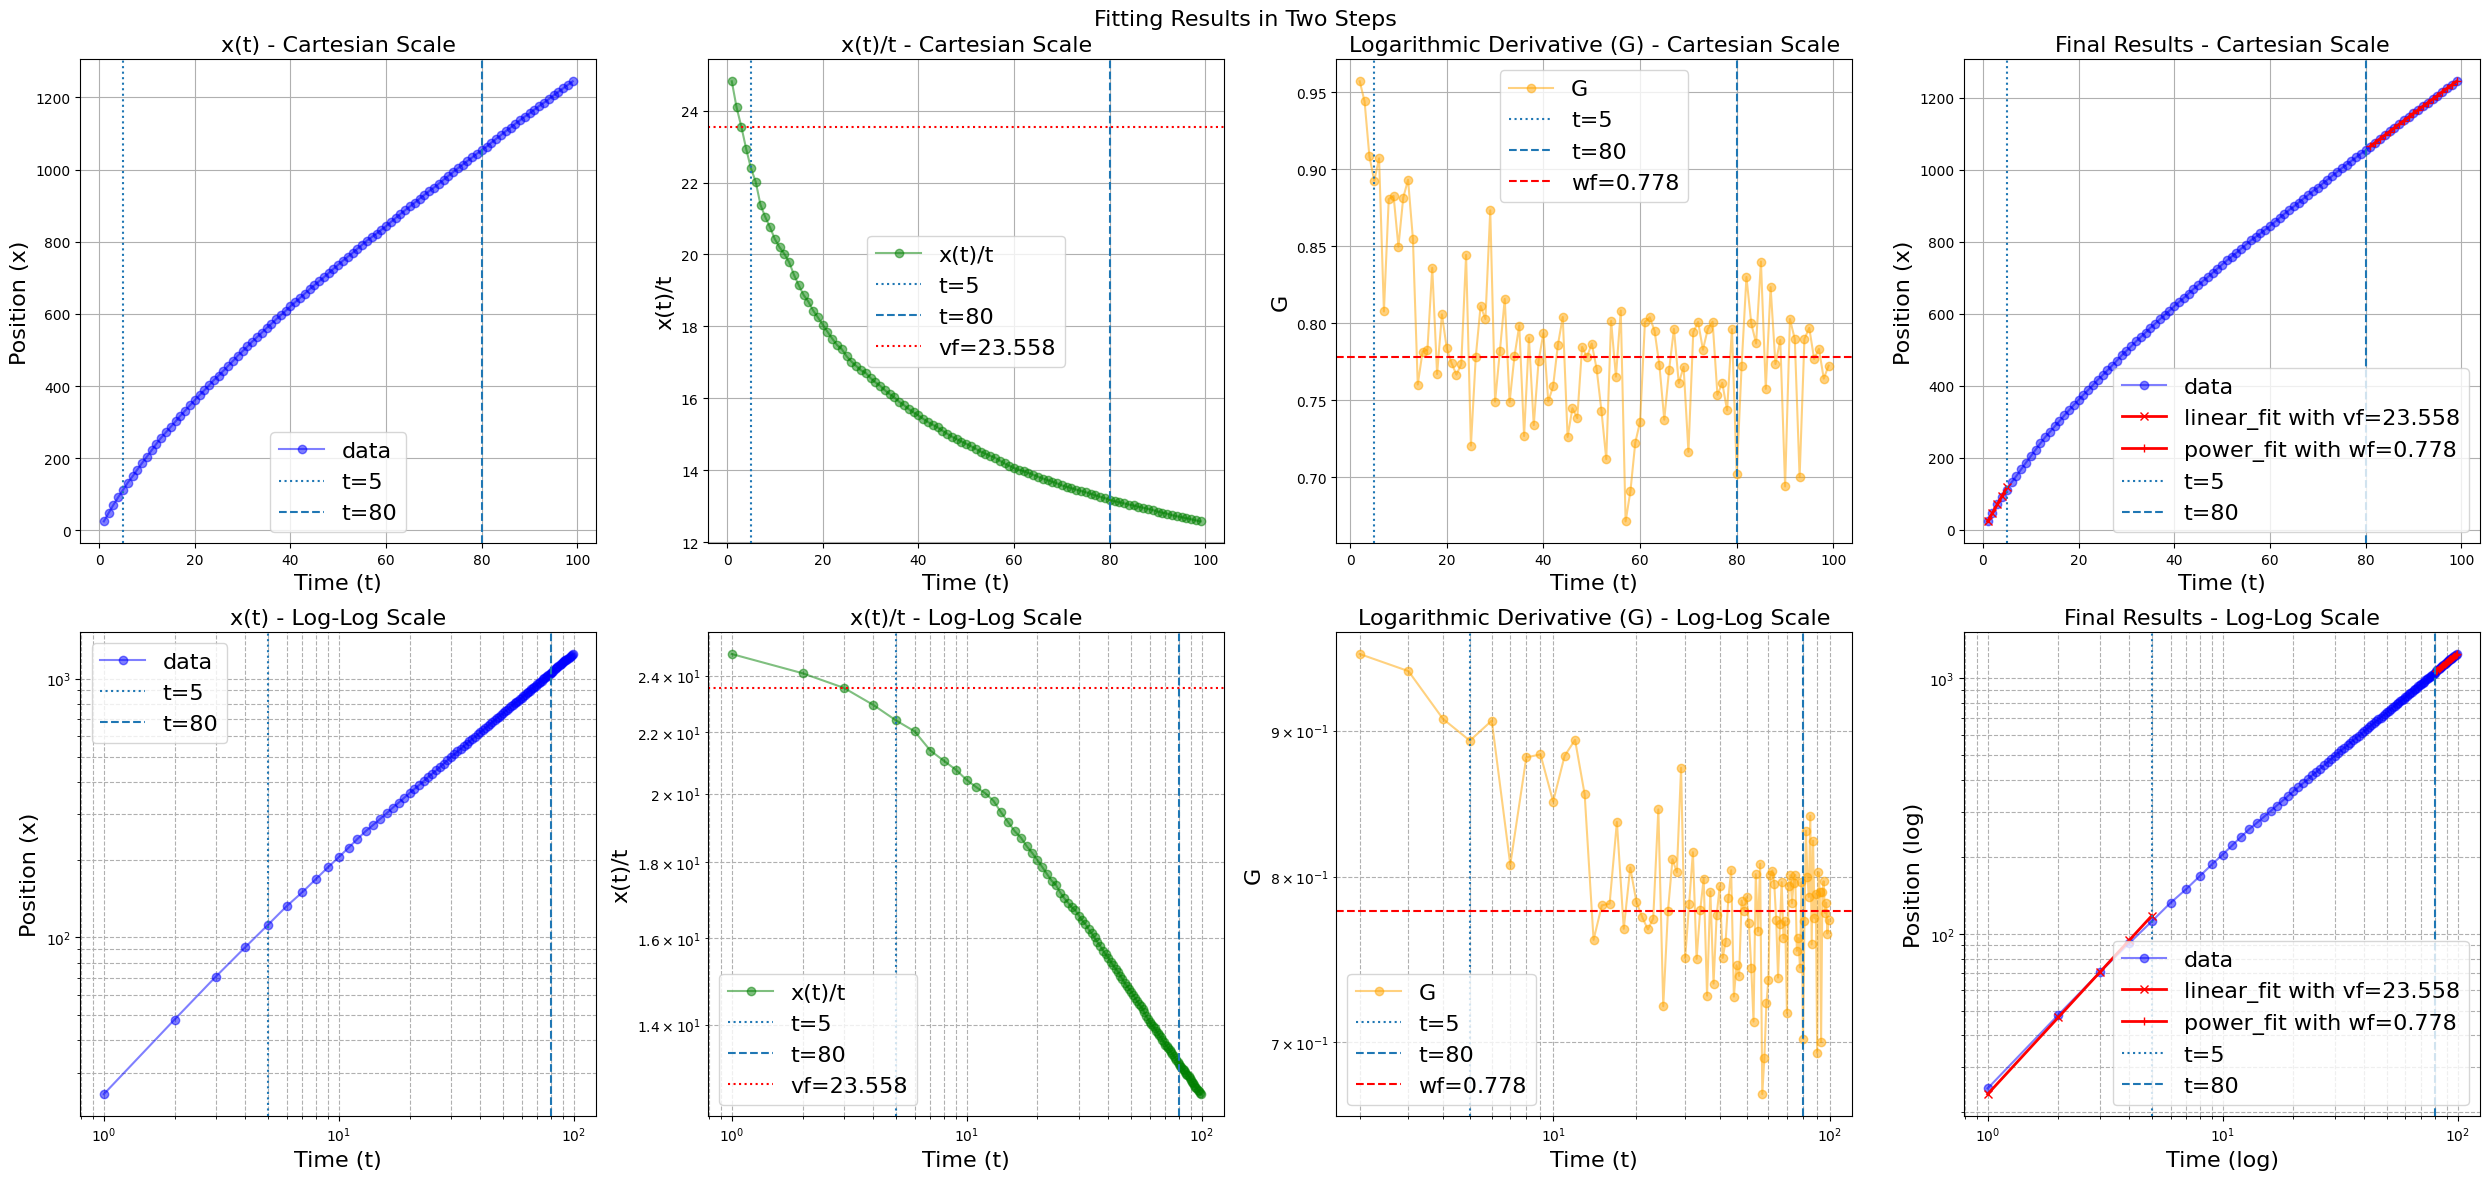


vf_os = 23.558 with vf_std_os = 0.848 
Cf_os = 34.825 with Cf_std_os = 0.324 
wf_os = 0.778 with wf_std_os = 0.002


In [11]:
# --- One scenario --- #


# Big subplot
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
axes = axes.flatten()
text_size = 16

plot_functions = [
    (plot_obstacle, (s, l, origin, alpha_mean)),
    (plot_obs_linker_distrib, (obs_points, obs_distrib, link_points, link_distrib)),
    (plot_probabilities, (mu, theta, p)),
    (plot_trajectories, (tmax, times, results, results_mean, results_med, results_std, v_mean, v_med)),
    (plot_fpt_distrib_2d, (fpt_distrib_2D, tmax, bin_fpt)),
    (plot_fpt_number, (nt, tmax, fpt_number, bin_fpt)),
    (plot_waiting_times, (tbj_points, tbj_distrib)),
    (plot_speed_distribution, (vi_points, vi_distrib, vi_mean, vi_med, vi_mp))
]

for i, (plot_func, args) in enumerate(plot_functions):
    plot_func(*args, ax=axes[i])

plt.tight_layout()
plt.show()


# Fitting
vf_os, Cf_os, wf_os , vf_std_os, Cf_std_os, wf_std_os = fitting_in_two_steps(times, results_mean, results_std, bound_low=5, bound_high=80, rf=3, plot=True)
print(
    "\nvf_os =",vf_os, "with vf_std_os =", vf_std_os,
    "\nCf_os =",Cf_os, "with Cf_std_os =", Cf_std_os,
    "\nwf_os =",wf_os, "with wf_std_os =", wf_std_os
)

# Parquet fusion

In [5]:
# --- Dialog box to merge all the parquet files together --- #

def ask_confirmation_input():
    response = input("Are you sure you want to merge all the parquet files? (Yes/No): ")
    if response != "Yes":
        raise RuntimeError("Stopped by the user.")

ask_confirmation_input()
print("Ready.")

Ready.


In [6]:
# --- Big fusion --- #

def merging_parquet_files(root_directory, nt, tmax, dt, alphao, alphaf, beta, Lmin, Lmax, origin, bps):
    """
    Merges all the .parquet files from our simulations while filtering only columns of types str, i64, and f64.

    Args:
        root_directory (str): Root directory containing subfolders.
        L_max (int): Filter parameter for subfolders.
        n_t (int): Filter parameter for subfolders.

    Returns:
        None
    """

    os.chdir(root_directory)  # Navigate to root directory to avoid unwanted paths
    print('Launched at:', os.getcwd())

    # Main result storage
    dataframes = []

    # List of subfolders to check in the root folder
    subdirs = [os.path.join(root_directory, d) for d in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, d))]

    # Main loop
    for subdir in tqdm(subdirs, desc="Loading subfiles", unit=" subfiles"):
        for dirpath, dirnames, filenames in os.walk(subdir):
            for dirname in dirnames:
                folder_name = dirname
                # Verification
                if (f"nt_{nt}_" in folder_name and 
                    f"tmax_{tmax}" in folder_name and 
                    f"dt_{dt}" in folder_name and 
                    f"alphao_{alphao}" in folder_name and 
                    f"alphaf_{alphaf}" in folder_name and 
                    f"beta_{beta}" in folder_name and 
                    f"Lmin_{Lmin}" in folder_name and 
                    f"Lmax_{Lmax}" in folder_name and 
                    f"origin_{origin}" in folder_name and 
                    f"bps_{bps}" in folder_name 
                    ):
                    # Path of the corresponding subfolder
                    subdir_path = os.path.join(dirpath, folder_name)

                    for filename in os.listdir(subdir_path):
                        if filename.endswith('.parquet') and 'data' in filename:
                            pq_path = os.path.join(subdir_path, filename)

                            try:
                                # Read the parquet file
                                df_parquet = pl.read_parquet(pq_path)

                                # Filter only columns of type str, i64, or f64
                                filtered_df = df_parquet.select([
                                    col for col, dtype in zip(df_parquet.columns, df_parquet.dtypes)
                                    if dtype in [pl.Utf8, pl.Int64, pl.Float64]
                                ])
                                
                                dataframes.append(filtered_df)

                            except Exception as e:
                                print(f"Error loading Parquet file: {e}")
    
    # Concatenate and write the final result
    if dataframes:
        merged_df = pl.concat(dataframes)
        last_address = f'{root_directory}/z_output.parquet'
        merged_df.write_parquet(last_address)
        print(f"All files merged and saved to {last_address}.")
    else:
        print("No Parquet files found that match the criteria.")

    return None


# --- Launching --- #k
root = '/home/nicolas/Documents/Progs/nucleo_folder_Xnfs'
merging_parquet_files(root_directory=root, nt=10000, tmax=100, dt=1, alphao=0, alphaf=1, beta=0, Lmin=0, Lmax=50000, origin=10000, bps=1)

Launched at: /home/nicolas/Documents/Progs/nucleo_folder_Xnfs


Loading subfiles: 100%|██████████| 96/96 [42:07<00:00, 26.32s/ subfiles]  


All files merged and saved to /home/nicolas/Documents/Progs/nucleo_folder_Xnfs/z_output.parquet.


# Using the main file

In [12]:
# --- Verifications and filtering in case of --- #


# Reading it for further manipulations
main_file_path = '/home/nicolas/Documents/Progs/nucleo_folder_Xnfs/z_output.parquet'
data = pq.read_table(main_file_path)
df_polars = pl.DataFrame(data)
# print(df_polars.shape)
# print(df_polars.head(5))


# Getting the file with Polars and performing verifications
def getting_main_file_and_verification(df: pl.DataFrame):
    """
    Filters a Polars DataFrame based on specific criteria.

    Args:
        df (pl.DataFrame): DataFrame containing the dataset.

    Returns:
        pl.DataFrame: The filtered DataFrame.
    """
    selected_columns = {
        "alpha_choice", "s", "l", "bpmin", 
        "mu", "theta", 
        "nt", "tmax", "dt", "times", 
        "alphao", "alphaf", "beta",
        "Lmin", "Lmax", "origin", "bps",
        
        "v_mean", "v_med", 
        "vf", "Cf", "wf", "vf_std", "Cf_std", "wf_std", 
        "vi_mean", "vi_med", "vi_mp",
    }

    # Select only the required columns
    filtered_columns = [col for col in df.columns if col in selected_columns]
    filtered_df = df.select(filtered_columns)

    # Verify that all rows have 's' equal to 150
    if (filtered_df["s"] == 150).all():
        print("All rows have s = 150.")
    else:
        print("Some rows do not have s = 150.")
        print(filtered_df.filter(pl.col("s") != 150))

    # Apply filtering based on predefined conditions
    filtered_df = (
        filtered_df
        .filter(pl.col("nt") == nt)
        .filter(pl.col("tmax") == tmax)
        .filter(pl.col("dt") == dt)
        .filter(pl.col("alphao") == alphao)
        .filter(pl.col("alphaf") == alphaf)
        .filter(pl.col("beta") == beta)
        .filter(pl.col("Lmin") == Lmin)
        .filter(pl.col("Lmax") == Lmax)
        .filter(pl.col("origin") == origin)
        .filter(pl.col("bps") == bps)
    )

    return filtered_df



# Creating an order for the configurations
def df_polar_ordering(data_frame): 
    """We're extracting the different configurations of modeling and ordering them for a proper representation

    Args:
        data_frame (df): filtered data frame

    Returns:
        sorted_combinations_configs: the configurations
    """

    df = data_frame                             # More convinient
    filtered_combinations = df.filter(
        ~(
            ((pl.col("alpha_choice") == 'periodic') | (pl.col("alpha_choice") == 'constant_mean')) &
            (pl.col("bpmin") == 5)
        )
    )

    # Getting the unique combinations of 's', 'l', 'bpmin' and 'alpha_choice'
    unique_combinations = filtered_combinations.select(['s', 'l', 'bpmin', 'alpha_choice']).unique()

    # Ordering it by alpha_choice in priority
    alpha_order = pl.when(pl.col("alpha_choice") == 'constant_mean').then(1)\
                    .when(pl.col("alpha_choice") == 'periodic').then(2)\
                    .when(pl.col("alpha_choice") == 'nt_random').then(3)\
                    .otherwise(4)
    unique_combinations = unique_combinations.with_columns(
        alpha_order.alias("alpha_order")
    )

    # Ordering by 'alpha_order', then by 'bpmin', and finally by 'l' with l=10 prioritazed
    sorted_combinations = unique_combinations.sort(by=['alpha_order', 'bpmin', 'l'])

    # Suppressing the temporary column 'alpha_order'
    sorted_combinations = sorted_combinations.drop('alpha_order')

    # Convertiing it into a list of dict
    sorted_combinations_configs = sorted_combinations.rows()
    sorted_combinations_configs = [
        {"s": row[0], "l": row[1], "bpmin": row[2], "alpha_choice": row[3]} 
        for row in sorted_combinations_configs
    ]

    # Print
    for config in sorted_combinations_configs:
        print(config)

    return sorted_combinations_configs


# Loading file + Filtering
df_pl_main = getting_main_file_and_verification(df_polars)
print('The df_polars containing the int and floats for all our simulations :\nTotal shape :',df_pl_main.shape, '\nQuick print and shape :', df_pl_main.head(5))

# Getting unique combinations
print('\nConfigurations :')
sorted_combinations_configs = df_polar_ordering(df_pl_main)

All rows have s = 150.
The df_polars containing the int and floats for all our simulations :
Total shape : (131300, 27) 
Quick print and shape : shape: (5, 27)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ alp ┆ s   ┆ l   ┆ bpm ┆ mu  ┆ the ┆ nt  ┆ tma ┆ dt  ┆ alp ┆ alp ┆ bet ┆ Lmi ┆ Lma ┆ ori ┆ bps ┆ v_m ┆ v_m ┆ vf  ┆ Cf  ┆ wf  ┆ vf_ ┆ Cf_ ┆ wf_ ┆ vi_ ┆ vi_ ┆ vi_ │
│ ha_ ┆ --- ┆ --- ┆ in  ┆ --- ┆ ta  ┆ --- ┆ x   ┆ --- ┆ hao ┆ haf ┆ a   ┆ n   ┆ x   ┆ gin ┆ --- ┆ ean ┆ ed  ┆ --- ┆ --- ┆ --- ┆ std ┆ std ┆ std ┆ mea ┆ med ┆ mp  │
│ cho ┆ i64 ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ i64 ┆ --- ┆ --- ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ --- ┆ --- ┆ n   ┆ --- ┆ --- │
│ ice ┆     ┆     ┆ i64 ┆     ┆ i64 ┆     ┆ i64 ┆     ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆     ┆ f64 ┆ f64 ┆     ┆     ┆     ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64 │
│ --- ┆     ┆     ┆ 

# 2D

In [ ]:
# --- Dialog box to compute the 2D heatmap --- #

def ask_confirmation_input():
    response = input("Are you sure you want to compute the 2D heatmap ? (Yes/No): ")
    if response != "Yes":
        raise RuntimeError("Stopped by the user.")

ask_confirmation_input()
print("Ready.")

In [8]:
# --- Creating the main polar file --- #


def compute_heatmap_data(df: pl.DataFrame, config_list: list, speed_cols: list) -> dict:
    """
    Computes and stores heatmap data for each configuration and speed column.

    Args:
        df (pl.DataFrame): Data containing multiple speed configurations.
        config_list (list): List of configuration dictionaries.
        speed_cols (list): List of speed columns to process.

    Returns:
        dict: Nested dictionary {config_idx -> {speed_col -> heatmap_data, config_metadata}}.
    """

    all_data = {}

    for idx, config in tqdm(enumerate(config_list), total=len(config_list), desc="Computing heatmaps"):

        df_filtered = df.filter(
            (pl.col('s') == config['s']) &
            (pl.col('l') == config['l']) &
            (pl.col('bpmin') == config['bpmin']) &
            (pl.col('alpha_choice') == config['alpha_choice'])
        )

        if df_filtered.is_empty():
            print(f"No data for config {config}")
            continue

        mu_values = df_filtered['mu'].unique().sort()
        theta_values = df_filtered['theta'].unique().sort()

        # Store configuration metadata
        all_data[idx] = {
            "mu_values": mu_values,
            "theta_values": theta_values,
            "config": config  # Store full config metadata (s, l, bpmin, alpha_choice)
        }

        for speed_col in speed_cols:
            heatmap_data = []

            for theta in tqdm(theta_values, desc=f"Processing theta for config {idx}", leave=False):
                row = []
                for mu in mu_values:
                    values = df_filtered.filter((pl.col('mu') == mu) & (pl.col('theta') == theta))[speed_col].mean()

                    normalization_factor = ((df_filtered['alphao'][0] * df_filtered['s'][0] +
                                             df_filtered['alphaf'][0] * df_filtered['l'][0]) /
                                            (df_filtered['l'][0] + df_filtered['s'][0])) * mu

                    # Normalize or keep values
                    if speed_col in {'v_mean', 'vi_med', 'vi_mp', 'vf'}:
                        row.append(values / normalization_factor if values is not None else 0)
                    elif speed_col in {'Cf', 'wf'}:
                        row.append(values if values is not None else 0)

                heatmap_data.append(row)

            all_data[idx][speed_col] = np.array(heatmap_data)

    return all_data


# --- Compute and Save Data --- #
speed_columns = ['v_mean', 'vi_med', 'vi_mp', 'vf', 'Cf', 'wf']
computed_data = compute_heatmap_data(df_pl_main, sorted_combinations_configs, speed_columns)

# Save to a file for later use
with open("heatmap_data.pkl", "wb") as f:
    pickle.dump(computed_data, f)

print("Computation completed and saved!")

Computing heatmaps:  15%|█▌        | 2/13 [01:08<06:18, 34.40s/it]

Plotting heatmaps: 100%|██████████| 13/13 [00:00<00:00, 27.54it/s]


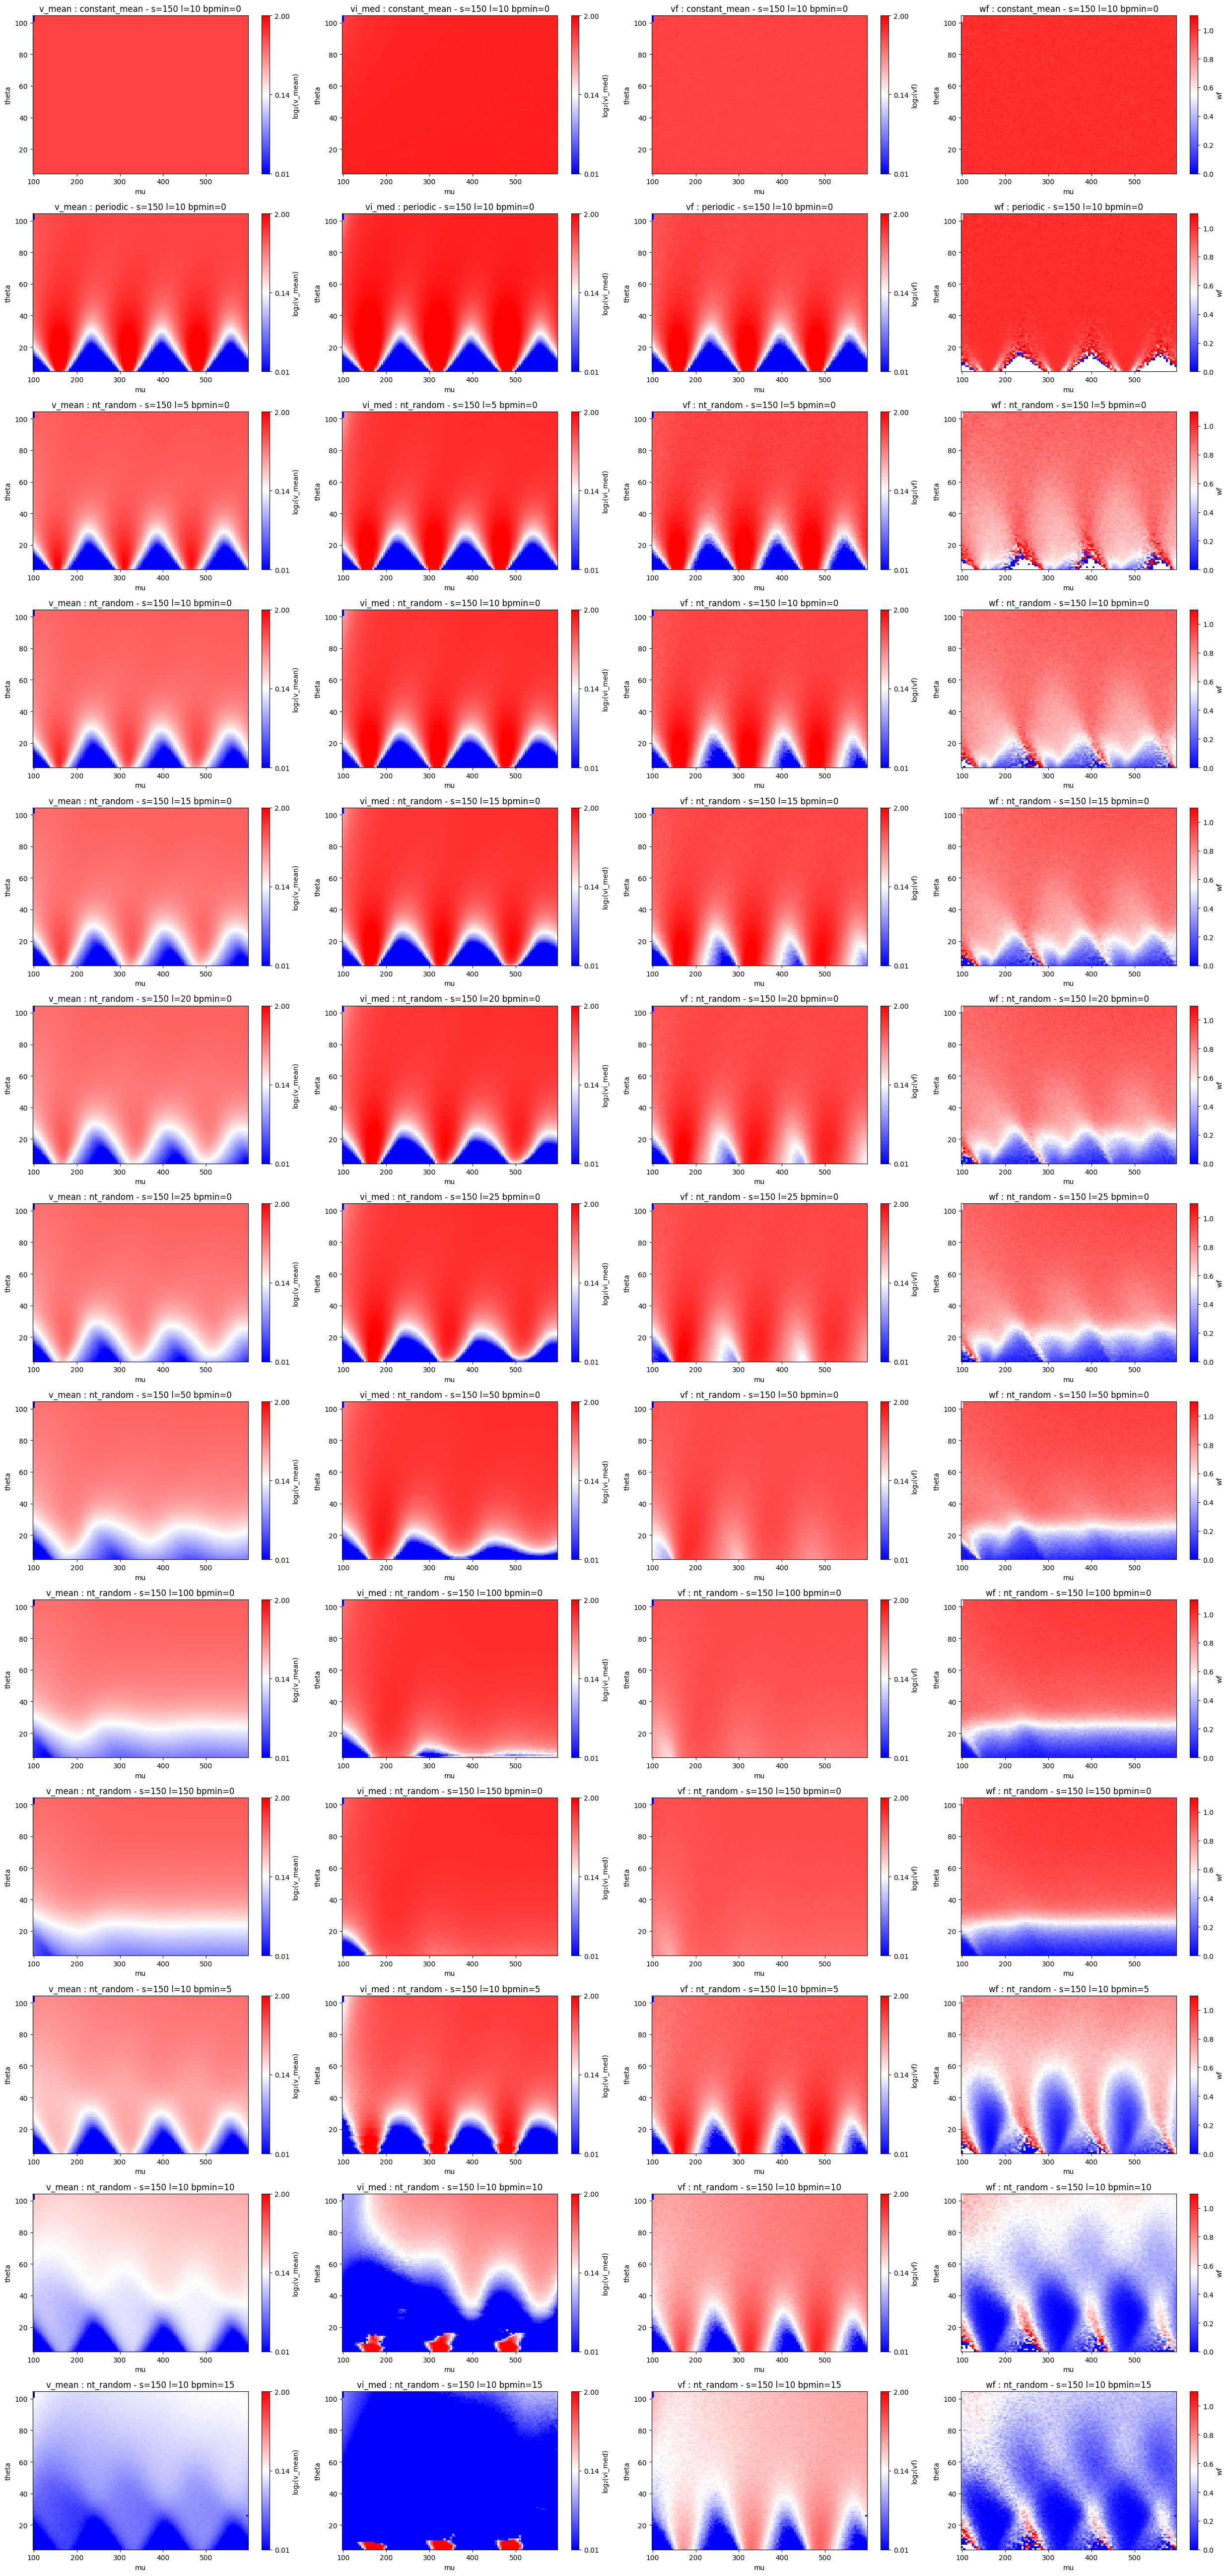

In [26]:
# --- Plotting the results --- #


def plot_precomputed_heatmaps(computed_data, speed_cols, min_values=0.01, max_values=None, plot_log2=True):
    """
    Plots precomputed heatmap data with an option for logarithmic scale (log2) for speed variables.
    
    Args:
        computed_data (dict): Dictionary containing precomputed heatmap data.
        speed_cols (list): List of columns to plot.
        max_values (dict, optional): Custom max values for each column.
        plot_log2 (bool): If True, plots speed variables in log2 scale; otherwise, plots all in Cartesian scale.
    """

    # Plot initialization
    n_combinations = len(computed_data)
    fig, axes = plt.subplots(nrows=n_combinations, ncols=len(speed_cols), figsize=(25, 4 * n_combinations))
    axes = np.atleast_2d(axes)  # Ensure it's always a 2D arr

    # Main
    for idx, config_data in tqdm(computed_data.items(), total=len(computed_data), desc="Plotting heatmaps"):
        mu_values = config_data["mu_values"]
        theta_values = config_data["theta_values"]
        config = config_data["config"]

        for col_idx, speed_col in enumerate(speed_cols):
            ax = axes[idx, col_idx]

            # Get precomputed heatmap data
            heatmap_data = config_data[speed_col]

            # Check if we apply log2 (only for speed variables) or keep cartesian scale
            if plot_log2 and speed_col in ["v_mean", "vi_med", "vi_mp", "vf"]:
                heatmap_transformed = np.log2(heatmap_data + 1e-10)  # Convert to log2
                min_speed = np.log2(min_values.get(speed_col, np.min(heatmap_data))) if min_values else np.min(heatmap_data)
                max_speed = np.log2(max_values.get(speed_col, np.max(heatmap_data))) if max_values else np.max(heatmap_transformed)
                colorbar_label = f"log₂({speed_col})"
                log_scale = True
            else:
                heatmap_transformed = heatmap_data  # Keep original scale
                min_speed = min_values.get(speed_col, np.min(heatmap_data)) if min_values else np.min(heatmap_data)
                max_speed = max_values.get(speed_col, np.max(heatmap_data)) if max_values else np.max(heatmap_data)
                colorbar_label = speed_col
                log_scale = False

            # Plot heatmap
            c = ax.pcolormesh(mu_values, theta_values, heatmap_transformed, cmap='bwr', vmin=min_speed, vmax=max_speed)

            # Restore full title with metadata
            ax.set_title(f"{speed_col} : {config['alpha_choice']} - s={config['s']} l={config['l']} bpmin={config['bpmin']}")
            ax.set_xlabel("mu")
            ax.set_ylabel("theta")

            # Add colorbar
            cbar = plt.colorbar(c, ax=ax)
            cbar.set_label(colorbar_label)

            # Adjust colorbar ticks if log scale
            if log_scale:
                log_ticks = np.linspace(min_speed, max_speed, num=3)
                cbar.set_ticks(log_ticks)
                cbar.set_ticklabels([f"{2**tick:.2f}" for tick in log_ticks])  # Convert back to original scale

    plt.tight_layout()
    plt.show()

# --- Load Data and Plot --- #
with open("heatmap_data.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Define custom max values if needed
custom_min_values = {'v_mean': 0.01, 'vi_med': 0.01, 'vi_mp': 0.01, 'vf': 0.01, 'Cf': 0.00, 'wf': 0.00}
custom_max_values = {'v_mean': 2, 'vi_med': 2, 'vi_mp': 2, 'vf': 2, 'Cf': 250, 'wf': 1.1}

# --- Call function with desired mode --- #
# plot_precomputed_heatmaps(loaded_data, ["v_mean", "vi_med", "vi_mp", "vf", "Cf", "wf"], min_values=custom_min_values, max_values=custom_max_values, plot_log2=True)
# plot_precomputed_heatmaps(loaded_data, ["v_mean", "vi_med", "vf", "wf"], min_values=custom_min_values, max_values=custom_max_values, plot_log2=True)
plot_precomputed_heatmaps(loaded_data, ["v_mean", "vi_med", "vf", "wf"], min_values=custom_min_values, max_values=custom_max_values, plot_log2=True)

Plotting heatmaps: 100%|██████████| 13/13 [00:00<00:00, 13.22it/s]


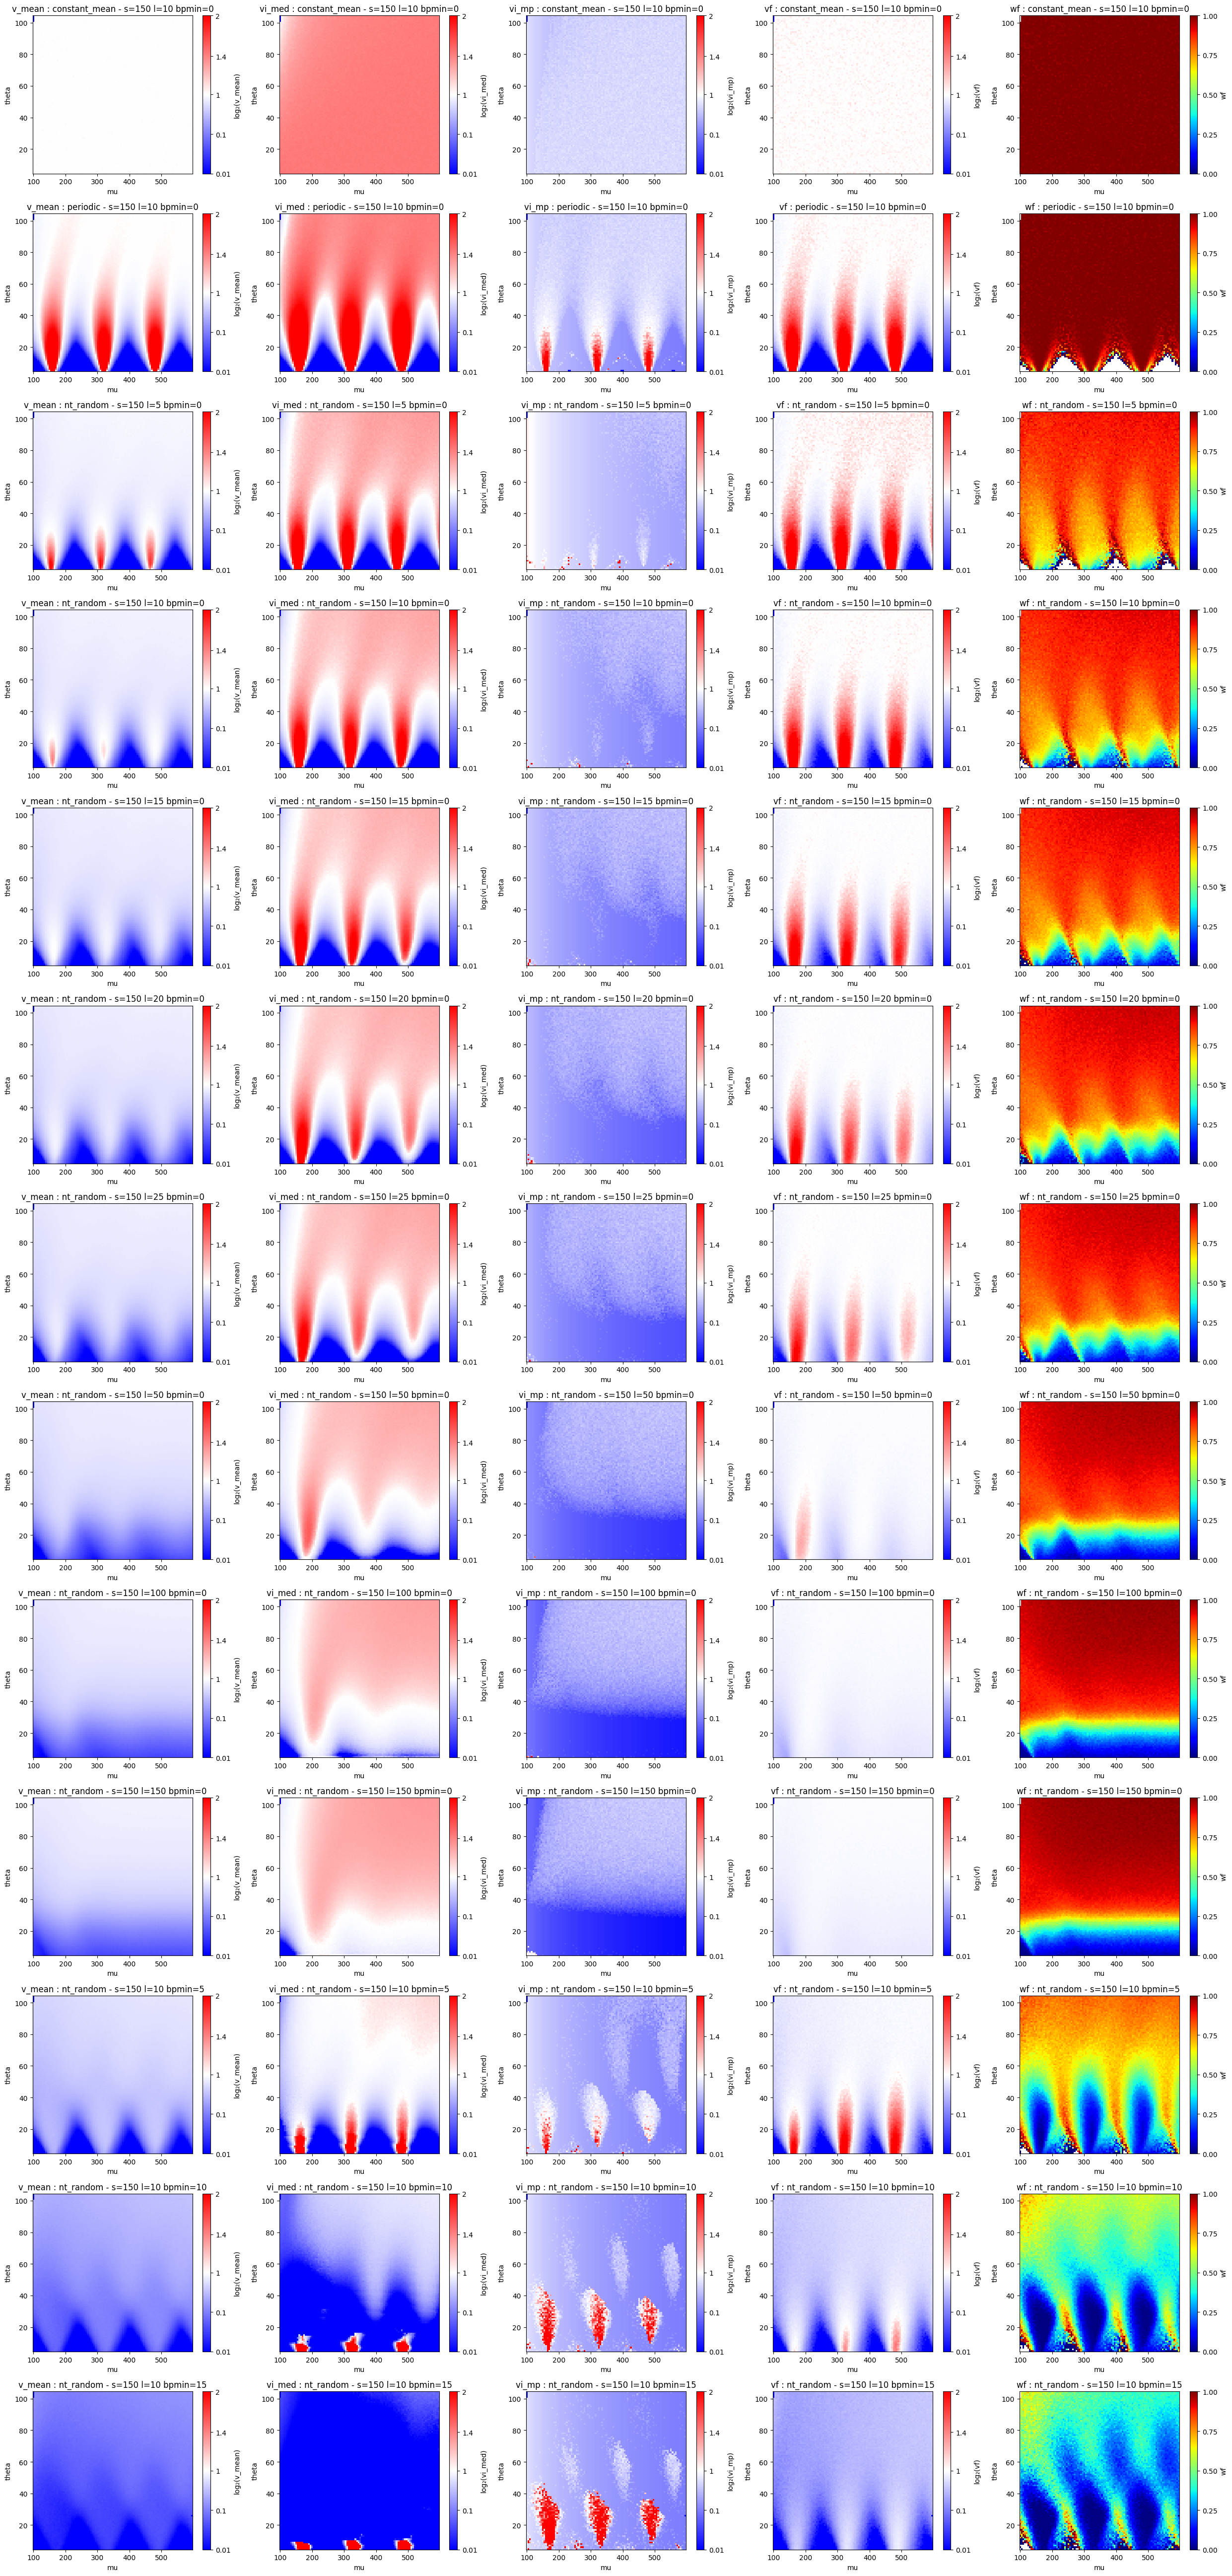

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import Normalize, TwoSlopeNorm
import pickle

def plot_precomputed_heatmaps(computed_data, speed_cols, min_values=None, max_values=None):
    """
    Plots heatmaps of either raw or log2-transformed values depending on the variable:
    - log2 + bwr for all except wf
    - linear + jet for wf
    """
    n_combinations = len(computed_data)
    fig, axes = plt.subplots(nrows=n_combinations, ncols=len(speed_cols), figsize=(25, 4 * n_combinations))
    axes = np.atleast_2d(axes)

    for idx, (key, config_data) in enumerate(tqdm(computed_data.items(), total=n_combinations, desc="Plotting heatmaps")):
        mu_values = config_data["mu_values"]
        theta_values = config_data["theta_values"]
        config = config_data["config"]

        for col_idx, speed_col in enumerate(speed_cols):
            ax = axes[idx, col_idx]
            raw_data = config_data[speed_col]

            if speed_col == "wf":
                # Plot raw data with jet colormap and linear scale
                vmin = min_values.get(speed_col, np.nanmin(raw_data)) if min_values else np.nanmin(raw_data)
                vmin = 0
                vmax = max_values.get(speed_col, np.nanmax(raw_data)) if max_values else np.nanmax(raw_data)
                vmax = 1
                norm = Normalize(vmin=vmin, vmax=vmax)
                cmap = 'jet'
                display_data = raw_data
                cbar_label = f"{speed_col}"
                tick_values = np.linspace(vmin, vmax, num=5)

                # Plot
                c = ax.pcolormesh(mu_values, theta_values, display_data, cmap=cmap, norm=norm)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(cbar_label)
                cbar.set_ticks(tick_values)
                cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])

            else:
                # Log2 display with bwr colormap
                log_data = np.log2(raw_data + 1e-10)
                log_min = np.log2(0.01)
                log_max = np.log2(2)
                log_center = 0
                norm = TwoSlopeNorm(vmin=log_min, vcenter=log_center, vmax=log_max)
                cmap = 'bwr'
                display_data = log_data
                cbar_label = f"log₂({speed_col})"
                tick_values = [0.01, 0.1, 1, 1.4, 2] 

                # Plot
                c = ax.pcolormesh(mu_values, theta_values, display_data, cmap=cmap, norm=norm)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(cbar_label)
                cbar.set_ticks(np.log2(tick_values))
                cbar.set_ticklabels([str(v) for v in tick_values])

            # Titles and labels
            ax.set_title(f"{speed_col} : {config['alpha_choice']} - s={config['s']} l={config['l']} bpmin={config['bpmin']}")
            ax.set_xlabel("mu")
            ax.set_ylabel("theta")

    plt.tight_layout()
    plt.show()



# --- Load Data and Plot --- #
with open("heatmap_data.pkl", "rb") as f:
    loaded_data = pickle.load(f)

plot_precomputed_heatmaps(
    loaded_data,
    speed_cols=["v_mean", "vi_med", "vi_mp", "vf", "wf"]
)

# 3D

In [15]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

def plot_3D(_df_, _config_):

    # Filtering datas
    _df_filtered_ = _df_.filter(
        (pl.col('s') == _config_['s']) &
        (pl.col('l') == _config_['l']) &
        (pl.col('bpmin') == _config_['bpmin']) &
        (pl.col('alpha_choice') == _config_['alpha_choice'])
    )
    
    # If empty
    if _df_filtered_.is_empty():
        print('No data corresponds to the given configuration.')
        return None

    # Unique values
    k_values = _df_filtered_['k'].unique().sort()
    theta_values = _df_filtered_['theta'].unique().sort()

    # Function in order to get the datas
    def get_normalized_values(col_name):
        heatmap_data = []
        for theta in theta_values:
            row = []
            for k in k_values:
                values = _df_filtered_.filter(
                    (pl.col('k') == k) & (pl.col('theta') == theta)
                )[col_name].mean()    
                alpha_o = _df_filtered_['alpha_o'][0]
                alpha_f = _df_filtered_['alpha_f'][0]
                s = _df_filtered_['s'][0]
                l = _df_filtered_['l'][0] 
                normalization_factor = ((alpha_o * s + alpha_f * l) / (l + s))
                row.append(values / normalization_factor)
            heatmap_data.append(row)
        return np.array(heatmap_data).flatten()  
        # 1D for plotting

    # Using the function
    v_mean_values = get_normalized_values('v_mean')
    vi_med_values = get_normalized_values('vi_med')

    # Proper format of the datas
    k_vals, theta_vals = np.meshgrid(k_values, theta_values)
    k = k_vals.flatten()
    theta = theta_vals.flatten()

    # Subplot
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("v_mean Normalized", "vi_med Normalized"),
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]]
    )

    # v_mean
    trace_v_mean = go.Scatter3d(
        x=k,
        y=theta,
        z=v_mean_values,
        mode='markers',
        marker=dict(
            size=5,
            color=v_mean_values,
            colorscale='Viridis',
            opacity=0.8
        )
    )

    # vi_med
    trace_vi_med = go.Scatter3d(
        x=k,
        y=theta,
        z=vi_med_values,
        mode='markers',
        marker=dict(
            size=5,
            color=vi_med_values,
            colorscale='Cividis',
            opacity=0.8
        )
    )

    # Subplot filling
    fig.add_trace(trace_v_mean, row=1, col=1)
    fig.add_trace(trace_vi_med, row=1, col=2)

    fig.update_layout(
        title=f'Comparaison v_mean et vi_med (s={_config_["s"]}, l={_config_["l"]}, bp_min={_config_["bp_min"]}, alpha_choice={_config_["alpha_choice"]})',
        width=2000,
        height=1000,
        scene=dict(
            xaxis_title="k values",
            yaxis_title="theta values",
            zaxis_title="v_mean Normalized"
        ),
        scene2=dict(
            xaxis_title="k values",
            yaxis_title="theta values",
            zaxis_title="vi_med Normalized"
        )
    )

    fig.show()

#--
config = {'s': 150, 'l': 10, 'bp_min': 10, 'alpha_choice': 'nt_random'}
plot_3D(df_pl_main, config)


NameError: name 'df_pl_main' is not defined

In [16]:
# print(sorted_combinations_configs)



def data_1D_function_of_k(df, config, theta, speed_col) : 
    """plot all the values of one speed for one selected theta in function of all the k

    Args:
        df (data frame): main results
        config (dict): scenario studied
        theta (i64): the theta desired
        speed_col (str): speed desired

    Returns:
        _type_: 2 lists
    """

    # Filtrering
    df_filtered = df.filter(
        (pl.col('s') == config['s']) &
        (pl.col('l') == config['l']) &
        (pl.col('bp_min') == config['bp_min']) &
        (pl.col('alpha_choice') == config['alpha_choice']) &
        (pl.col('theta') == theta)
    )

    # Select unique (k, v) pairs to ensure matched lengths
    k_values = df_filtered['k'].sort() 
    k_values = k_values.to_list()
    v_values = df_filtered[speed_col].sort()
    v_values = v_values.to_list()
    
    return (k_values, v_values)



def data_1D_function_of_theta(df, config, k, speed_col) : 
    """plot all the values of one speed for one selected k in function of all the theta

    Args:
        df (data frame): main results
        config (dict): scenario studied
        k (i64): the k desired
        speed_col (str): speed desired

    Returns:
        _type_: 2 lists
    """

    # Filtrering
    df_filtered = df.filter(
        (pl.col('s') == config['s']) &
        (pl.col('l') == config['l']) &
        (pl.col('bpmin') == config['bpmin']) &
        (pl.col('alpha_choice') == config['alpha_choice']) &
        (pl.col('k') == k)
    )

    # Select unique (theta, v) pairs to ensure matched lengths
    theta_values = df_filtered['k']
    theta_values = theta_values.to_list()
    v_values = df_filtered[speed_col]
    v_values = v_values.to_list()
    
    return (theta_values, v_values)




#- 
theta_list = df_pl_main['theta'].unique()
config = sorted_combinations_configs[2]
print(config)



plt.figure(figsize=(8,6))

for theta in theta_list :
    k,v = data_1D_function_of_k(df_pl_main, config, theta, 'v_mean')
    plt.scatter(k,v,label=f'theta={theta}')
    plt.legend()
plt.show()

NameError: name 'df_pl_main' is not defined

In [17]:
def data_1D_function_of_scenario(df, config, theta, speed_col) : 
    """plot all the values of one speed for one selected k in function of all the theta

    Args:
        df (data frame): main results
        speed_col (str): speed desired

    Returns:
        _type_: 2 lists
    """

    # Filtrering
    df_filtered = df.filter(
        (pl.col('s') == config['s']) &
        (pl.col('l') == config['l']) &
        (pl.col('bpmin') == config['bpmin']) &
        (pl.col('alpha_choice') == config['alpha_choice']) &
        (pl.col('theta') == theta)
    )

    # Select unique (k, v) pairs to ensure matched lengths
    k_values = df_filtered['k']# .sort() 
    k_values = k_values.to_list()
    v_values = df_filtered[speed_col]# .sort()
    v_values = v_values.to_list()
    
    return (k_values, v_values)


#- 
theta_w = 50
plt.figure(figsize=(15, 10))
colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_combinations_configs)))

for idx, config in enumerate(sorted_combinations_configs):
    k, v = data_1D_function_of_scenario(df_pl_main, config, theta_w, 'v_mean')
    plt.scatter(k, v, label=f'{config}', color=colors[idx], linewidth=2)

plt.legend(fontsize=10, loc='upper left', ncol=1)
plt.grid(True)
plt.title(f'v_mean in function of k, for different configurations for theta={theta_w}', fontsize=16)
plt.xlabel('k', fontsize=14)
plt.ylabel('v_mean', fontsize=14)
plt.ylim(0,200)
plt.show()

NameError: name 'sorted_combinations_configs' is not defined

<Figure size 1500x1000 with 0 Axes>

# 1D

In [7]:
print('hello')

hello


# .